<a href="https://colab.research.google.com/github/gregorio-saporito/hate-speech-detection/blob/main/main4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining and Sentiment Analysis: Hate Speech Detection
Gregorio Luigi Saporito - DSE (2020-2021)

### Reproducibility

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(123)
import random as rn
rn.seed(123)

### Libraries

In [2]:
!pip install text-preprocessing
!pip install tweet-preprocessor
!pip install -U nltk[twitter]
!pip install joblib

     |████████████████████████████████| 62.6MB 57kB/s 
     |████████████████████████████████| 2.7MB 26.1MB/s 
     |████████████████████████████████| 286kB 31.0MB/s 
     |████████████████████████████████| 327kB 43.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85394 sha256=55f3d4a769edcd9d69b276a6722baf00e996fdebd8a2f658861db2e41a2a74ed
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 1.5MB 4.0MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [3]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import preprocessor as p
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number, remove_punctuation, remove_whitespace, normalize_unicode, lemmatize_word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from tqdm import tqdm
from sklearn import utils
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statistics as st
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Upload the data to session storage
Upload here below the __labeled_data.csv__ file. The labels correspond to
- 0: hate speech
- 1: offensive language
- 2: neither

In [6]:
# upload here the .csv file "labeled_data.csv"
uploaded = files.upload()

Saving labeled_data.csv to labeled_data.csv


In [7]:
# read the csv file, select the columns of interest, and rename them
fields = ['Unnamed: 0', 'class', 'tweet']
raw = pd.read_csv('labeled_data.csv', usecols=fields)\
  .rename(columns={"Unnamed: 0": "id", "class": "label"})

### Inspect the data

In [8]:
# snapshot of the first rows
raw.head()

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
# size of the dataset
raw.shape

(24783, 3)

In [10]:
# inspect the presence of missing values
print(
    'Check for null values\n' +
    str(raw.isnull().sum()) + '\n'
    'Check for na values\n' +
    str(raw.isna().sum())
)

Check for null values
id       0
label    0
tweet    0
dtype: int64
Check for na values
id       0
label    0
tweet    0
dtype: int64


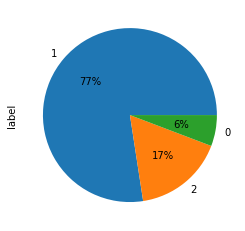

In [11]:
# inspect the classes' frequency
raw['label'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.show()

### Preprocessing text

In [12]:
# normalise tags, URLS, emoji, and smiley
# the hashtags are left out because they could contain hate speech to detect
p.set_options(p.OPT.MENTION, p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
raw['normalised'] = [p.tokenize(x) for x in raw['tweet']]

# Preprocess text using custom preprocess functions in the pipeline
def preprocess_txt(x):
  preprocess_functions = [to_lower, expand_contraction, remove_number, remove_punctuation,
                          remove_whitespace, normalize_unicode, lemmatize_word]
  preprocessed_text = preprocess_text(x, preprocess_functions)
  return preprocessed_text.replace("rt ", "").strip()

raw['cleaned'] = [preprocess_txt(x) for x in raw['normalised']]

### Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(raw['cleaned'], raw['label'], test_size=0.1, random_state=123)

### Doc2vec Custom Transformer

In [14]:
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, dm=1, size=1, window=1):
        self.d2v_model = None
        self.size = size
        self.window = window
        self.dm = dm

    def fit(self, raw_documents, y=None):
        # Initialize model
        self.d2v_model = Doc2Vec(workers=1, seed=123)
        # Tag docs
        tagged_documents = []
        for index, row in raw_documents.iteritems():
            tag = '{}_{}'.format("type", index)
            tokens = row.split()
            tagged_documents.append(TaggedDocument(words=tokens, tags=[tag]))
        # Build vocabulary
        self.d2v_model.build_vocab(tagged_documents)
        # Train model
        self.d2v_model.train(tagged_documents, total_examples=len(tagged_documents), epochs=self.d2v_model.epochs)
        return self

    def transform(self, raw_documents):
        X = []
        for index, row in raw_documents.iteritems():
            X.append(self.d2v_model.infer_vector(row))
        X = pd.DataFrame(X, index=raw_documents.index)
        return X
        
    def fit_transform(self, raw_documents, y=None):
        self.fit(raw_documents)
        return self.transform(raw_documents)

### Sentiment Custom Transformer

In [15]:
class SentimentTransformer( BaseEstimator, TransformerMixin ):
    
    # Class Constructor 
    def __init__( self ):
        return
    
    # Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
        
    # Method that describes what we need this transformer to do i.e.
    # returning length, digits and punctuations in the 'text' column in data frame
    def transform( self, X, y = None ):
      sia = SentimentIntensityAnalyzer()

      f           = pd.DataFrame()
      f['neg']    = [sia.polarity_scores(x)['neg'] for x in X]
      f['neu']    = [sia.polarity_scores(x)['neu'] for x in X]
      f['pos']    = [sia.polarity_scores(x)['pos'] for x in X]
      return f[['neg','neu','pos']]

### Dense Transformer

In [16]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

### 1) Latent Semantic Analysis (LSA) and Logistic Classifier

In [17]:
# vectoriser
tfidf = TfidfVectorizer(sublinear_tf=True, use_idf=True).fit_transform(X_train)
# check the shape
print('TF-IDF shape: ' + str(tfidf.shape))

TF-IDF shape: (22304, 19165)


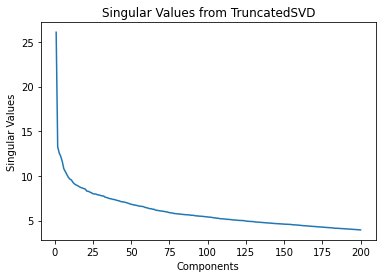

In [18]:
# TruncatedSVD
svd = TruncatedSVD(n_components=200, random_state=123).fit(tfidf)
# plot singular values to have an idea of how many components to select
fig = plt.figure()
ax = plt.axes()
ax.plot(range(1,201), svd.singular_values_)
plt.title('Singular Values from TruncatedSVD')
plt.xlabel('Components')
plt.ylabel('Singular Values')
plt.show()

In [19]:
# build pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
    ('lsa', TruncatedSVD(random_state=123)),
    ('logistic', LogisticRegression(max_iter=10000, class_weight='balanced', random_state=123)),
])

# test some components to select
param_grid = {'lsa__n_components': [100, 1000, 2000]}

log_grid = GridSearchCV(pipe, 
                        param_grid=param_grid,
                        scoring="balanced_accuracy",
                        verbose=3,
                        n_jobs=1,
                        cv = 3)

fitted = log_grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(log_grid.best_params_))
print("Best accuracy: {}\n".format(log_grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] lsa__n_components=100 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... lsa__n_components=100, score=0.767, total=   3.4s
[CV] lsa__n_components=100 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ............... lsa__n_components=100, score=0.761, total=   3.4s
[CV] lsa__n_components=100 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] ............... lsa__n_components=100, score=0.771, total=   3.6s
[CV] lsa__n_components=1000 ..........................................
[CV] .............. lsa__n_components=1000, score=0.795, total=  35.3s
[CV] lsa__n_components=1000 ..........................................
[CV] .............. lsa__n_components=1000, score=0.800, total=  34.4s
[CV] lsa__n_components=1000 ..........................................
[CV] .............. lsa__n_components=1000, score=0.805, total=  35.5s
[CV] lsa__n_components=2000 ..........................................
[CV] .............. lsa__n_components=2000, score=0.797, total= 1.5min
[CV] lsa__n_components=2000 ..........................................
[CV] .............. lsa__n_components=2000, score=0.797, total= 1.5min
[CV] lsa__n_components=2000 ..........................................
[CV] .............. lsa__n_components=2000, score=0.803, total= 1.7min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.6min finished


Best Parameters: {'lsa__n_components': 1000}

Best accuracy: 0.8001275086013887

Finished.


In [20]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.8086370644663581

### 2) Rich Feature Extraction (mixed), Feature Selection, Regularisation, and Logistic Classifier
A richer feature extraction is considered including the:
- TF-IDF transformer
- Doc2vec custom transformer
- Sentiment polarity custom transformer

In [ ]:
# build pipeline
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif)),
  ('to_dense', DenseTransformer()),
  ('scale', StandardScaler()),
  ('logistic', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=123, penalty='l2'))
])

# test some parameters (number of features and regularisation)
param_grid = {'select__k': [200, 300, 500]
}

log_grid = GridSearchCV(pipe, 
                        param_grid=param_grid,
                        scoring="balanced_accuracy",
                        verbose=3,
                        n_jobs=1,
                        cv = 3)

fitted = log_grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(log_grid.best_params_))
print("Best accuracy: {}\n".format(log_grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:  7.4min finished


Best Parameters: {'select__k': 300}

Best accuracy: 0.8005709327768286

Finished.


In [ ]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.8010112675118067

### 3) Random Forest

In [21]:
# build pipeline
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif)),
  ('tree', RandomForestClassifier(n_estimators=50, random_state=123))
])

# test some parameters
param_grid = {'select__k': [300, 500]}

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring="balanced_accuracy",
                    verbose=3,
                    n_jobs=1,
                    cv = 3)

fitted = grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(grid.best_params_))
print("Best accuracy: {}\n".format(grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] select__k=300 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... select__k=300, score=0.574, total=  57.7s
[CV] select__k=300 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.7s remaining:    0.0s


[CV] ....................... select__k=300, score=0.555, total=  57.1s
[CV] select__k=300 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] ....................... select__k=300, score=0.569, total=  58.1s
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.529, total=  58.8s
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.522, total=  55.5s
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.562, total=  56.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.7min finished


Best Parameters: {'select__k': 300}

Best accuracy: 0.5658625629519994

Finished.


In [22]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.5720744573836952

### 4) XGBoost


In [ ]:
# build pipeline
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif, k=300)),
  ('to_dense', DenseTransformer()),
  ('scale', StandardScaler()),
  ('xgb',  XGBClassifier(random_state=123, objective= 'multi:softprob',tree_method='hist'))
])

# test some parameters
param_grid = {'xgb__max_depth': [3, 6]}

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring="balanced_accuracy",
                    verbose=3,
                    n_jobs=1,
                    cv = 3)

fitted = grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(grid.best_params_))
print("Best accuracy: {}\n".format(grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] xgb__max_depth=3 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... xgb__max_depth=3, score=0.653, total=  52.3s
[CV] xgb__max_depth=3 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s remaining:    0.0s


[CV] .................... xgb__max_depth=3, score=0.640, total=  51.9s
[CV] xgb__max_depth=3 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] .................... xgb__max_depth=3, score=0.671, total=  52.2s
[CV] xgb__max_depth=6 ................................................
[CV] .................... xgb__max_depth=6, score=0.678, total= 1.0min
[CV] xgb__max_depth=6 ................................................
[CV] .................... xgb__max_depth=6, score=0.669, total= 1.0min
[CV] xgb__max_depth=6 ................................................


In [ ]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

### 5) Support Vector Machine

In [ ]:
# support vector machine
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif, k=300)),
  ('to_dense', DenseTransformer()),
  ('scale', StandardScaler()),
  ('svc',  SVC(random_state=123))
])

# test some parameters
param_grid = {'svc__class_weight': ['balanced', 'None']}

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring="balanced_accuracy",
                    verbose=3,
                    n_jobs=1,
                    cv = 3)

fitted = grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(grid.best_params_))
print("Best accuracy: {}\n".format(grid.best_score_))
print("Finished.")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.767, total= 2.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV] .................................... , score=0.769, total= 2.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s


[CV] .................................... , score=0.792, total= 2.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min finished


array([0.76748415, 0.76913463, 0.79172784])

In [ ]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

### 6) Neural Network

In [ ]:
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif, k=300)),
  ('to_dense', DenseTransformer()),
  ('scale', StandardScaler()),
  ('MLP',  MLPClassifier(activation='tanh', hidden_layer_sizes = 10, random_state=123, max_iter=500))
])

cross_val_score(pipe, X_train, y_train, scoring="balanced_accuracy", verbose=3, cv=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.678, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] .................................... , score=0.663, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] .................................... , score=0.673, total= 1.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min finished


array([0.67769385, 0.66262131, 0.67281853])